# Sample_Entropy

기본 예제를 통해 시계열 데이터에서 tsfresh 가 어떻게 특징값을 추출하고 사용할 수 있는지를 배우고 sample entropy값을 추출해봅니다.

로봇 실행 실패 데이터 셋을 사용해봅시다!

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load and visualize data

데이터 셋에 대하여
88가지 종류의 로봇(id = 1~88)이 실행을 성공했을 때(y = True)와 실패했을 때(y = False) 각 실행 마다 15 개(행)의 힘(F) 및 토크(T) 샘플이 제공되며, 이는 x, y 및 z축에 대해 일정한 시간 간격으로 측정되었다. 따라서 데이터 프레임의 각 행은 특정 실행(id), 시간 인덱스(time)를 가지고 6개 센서(F_x, F_y, F_z, T_x, T_y, T_z)의 각 측정을 포함한다.

** y : 로봇 실행이 성공했냐, 실패했냐. True, False로 구분되며 총 88개의 값

** df(x) :

- id : 실행 횟수(1~88번)
- time : 각 실행당 0~14
- F_x, F_y, F_z, T_x, T_y, T_z : 각 실행했을 때 힘(F) 및 토크(T) 센서 값.

In [2]:
# 데이터 다운로드
from tsfresh.examples import robot_execution_failures

robot_execution_failures.download_robot_execution_failures()
df, y = robot_execution_failures.load_robot_execution_failures()
display(df.head())
# display(df)
print(np.shape(df))

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


(1320, 8)


In [3]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [4]:
print(y.shape)
print(type(y))

(88,)
<class 'pandas.core.series.Series'>


먼저 로봇 실행을 성공했을 때와 실패했을 때의 센서값을 그려서 차이가 있는지 눈으로 확인해봅시다!

성공했을 때는 F_z값이 60 근처에서, 나머지 값들은 0 근처에서 나오는데, 실패하면 F_z값이 확 떨어져서 나오거나 나머지 값들도 거의 0에서 벗어나지 않음

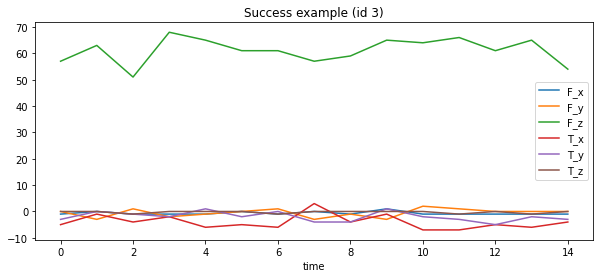

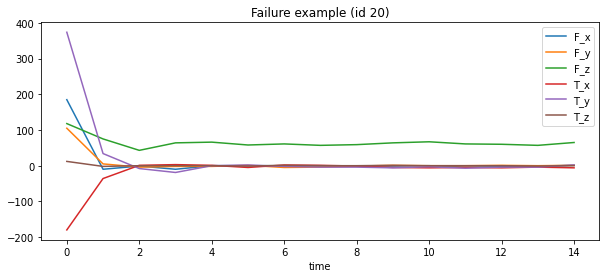

In [5]:
df[df.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Success example (id 3)', figsize=(10, 4));
df[df.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Failure example (id 20)', figsize=(10, 4));

# Extract Features

tsfresh를 사용하여 시계열 데이터의 특징을 추출 할 수 있다. 각 로봇(id)과 측정 된 각 센서 값(F_ * 및 T_ *)에 대한 특징을 추출할 것이다.

같은 id 별로, 그리고 각 센서축(열)별로 특징 값을 추출하게 된다. time 열을 기준으로 시간순으로 정렬해서 추출하게 된다.

추출할 특징 값들 중에서 sample_entropy만 추출한다.

In [6]:
# sample entropy
sampen_settings = {'sample_entropy': None}

In [7]:
sample_entropy = extract_features(df, column_id='id', column_sort='time',
                     default_fc_parameters=sampen_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 48/48 [00:00<00:00, 186.95it/s]


In [8]:
sample_entropy

,T_z__sample_entropy,F_x__sample_entropy,F_y__sample_entropy,F_z__sample_entropy,T_x__sample_entropy,T_y__sample_entropy
1,0.154151,0.182322,0.218689,0.510826,0.414434,0.606136
2,0.661398,1.011601,1.945910,0.437900,0.414434,2.079442
3,0.730888,0.847298,1.945910,0.437900,1.609438,2.079442
4,1.178655,1.945910,1.945910,0.437900,0.414434,0.693147
5,1.446919,1.466337,0.656093,1.504077,1.609438,2.079442
...,...,...,...,...,...,...
84,0.753772,0.538997,0.405465,0.451985,0.336472,0.693147
85,0.606136,0.693147,0.693147,1.504077,1.609438,0.693147
86,0.492476,0.182322,1.945910,0.405465,0.414434,0.510826
87,2.302585,0.287682,0.405465,0.310155,0.414434,0.810930


In [9]:
sample_entropy.head()

,T_z__sample_entropy,F_x__sample_entropy,F_y__sample_entropy,F_z__sample_entropy,T_x__sample_entropy,T_y__sample_entropy
1,0.154151,0.182322,0.218689,0.510826,0.414434,0.606136
2,0.661398,1.011601,1.945910,0.437900,0.414434,2.079442
3,0.730888,0.847298,1.945910,0.437900,1.609438,2.079442
4,1.178655,1.945910,1.945910,0.437900,0.414434,0.693147
5,1.446919,1.466337,0.656093,1.504077,1.609438,2.079442


In [10]:
sample_entropy.shape

(88, 6)

settings에서 sample_entropy 변수를 none으로 했기 때문에 6개 columns만 나왔다.

tsfresh를 사용해 sample_entropy 값과 sample_entropy함수를 사용해 구한 값을 비교해본다.

In [11]:
df

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [12]:
df2 = df[['id','time','F_y']] #원래 가진 data에서 'id', 'time', 'F_y' 만 뽑아서 df2로 설정

In [13]:
df2 = df2[df2['id'] == 1] #df2에서 다시 'id=1'인 것만 뽑아보려고 한다 (id는 1~88까지 존재)

In [14]:
df2

,id,time,F_y
0,1,0,-1
1,1,1,0
2,1,2,-1
3,1,3,-1
4,1,4,-1
5,1,5,-1
6,1,6,-1
7,1,7,-1
8,1,8,-1
9,1,9,-1


구하고 싶은 데이터를 자른 모습이다.

sample_entropy 함수에 넣기 위해 데이터를 np.array로 변환한다.

In [15]:
a = df2['F_y'].to_list() # df2에서 실제로 들어가는 값은 sensor가 인지한 'F_y'값이기에 'F_y' 값만 간추려서 list형으로 만든다

In [16]:
a = np.array(a) #np.array로 바꾼다
a

array([-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0])

sample entropy 함수를 사용해 sample entropy 값을 구한다.

_into_subchunks() 함수는
sample_entropy 함수를 실행하기 위해 필요한 함수.
시계열 데이터 x를 subchunk_length 길이를 가진 데이터로 나누고
각 하위 데이터의 시작 데이터는 전체 데이터에서 every_n씩 지나가면서 정해서 x를 subwindows로 분할한다.

In [17]:
def _into_subchunks(x, subchunk_length, every_n=1):
    len_x = len(x) # 데이터의 길이
#     print("len_x:",len_x)

    assert subchunk_length > 1 # 나눠질 각 데이터의 길이가 2 이상이어야 작동한다.
    assert every_n > 0 # 하위데이터는 1씩 이동하면서 시작 데이터를 정한다.

    # how often can we shift a window of size subchunk_length over the input?
    num_shifts = (len_x - subchunk_length) // every_n + 1 # 데이터가 생성된 횟수
#     print("num_shifts:",num_shifts)
    shift_starts = every_n * np.arange(num_shifts) #하위데이터의 시작데이터 인덱스 리스트
#     print("shift_starts:",shift_starts)
    indices = np.arange(subchunk_length) # 하위데이터 길이를 arange로 생성
#     print("indices:",indices)

    indexer = np.expand_dims(indices, axis=0) + np.expand_dims(shift_starts, axis=1)
    # 하위데이터의 길이 + 시작데이터가 움직인 위치를 이용해 데이터 차원을 확장한다.
#     print("indexer:",indexer)
#     print(np.expand_dims(indices, axis=0))
#     print(np.expand_dims(shift_starts, axis=1))
#     print("np.asarray(x)[indexer]:",np.asarray(x)[indexer])
    return np.asarray(x)[indexer] # 분할된 최종 결과물

In [18]:
x = [0,2,4,6,8,10,12]
into = _into_subchunks(x, 3, every_n=1)
into

array([[ 0,  2,  4],
       [ 2,  4,  6],
       [ 4,  6,  8],
       [ 6,  8, 10],
       [ 8, 10, 12]])

In [19]:
def sample_entropy(x):
    x = np.array(x) # 입력된 시계열 데이터

    if np.isnan(x).any(): # Nan 값이 있으면 계산을 진행하지 않는다.
        return np.nan

    m = 2  # embedding dimension 값, 일반적으로 2를 사용
    tolerance = 0.2 * np.std(x)# 허용오차 값, 0.2 * 데이터의 표준편차, 일반적으로 0.2를 사용
    print("tolerance:", tolerance)
    # 시계열 데이터를 m 길이로 저장한다.
    # 예시: [1, 2, 3, 4] into [1, 2], [2, 3], [3, 4]
    xm = _into_subchunks(x, m)
#     print("xm:",xm)

    B = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= tolerance) - 1 for xmi in xm])
    for xmi in xm:
#         print(np.abs(xmi - xm)) # subchunk 데이터끼리 거리 차이의 절대값
        print(np.abs(xmi - xm).max(axis=1)) # 절대값 중 최대값
        print(np.sum(np.abs(xmi - xm).max(axis=1))) # 최대값의 컬럼을 합친다.
        print(np.sum(np.abs(xmi - xm).max(axis=1) <= tolerance)) # tolerance를 기준으로 값을 구한다
    # print([np.sum(np.abs(xmi - xm).max(axis=1) <= tolerance) - 1 for xmi in xm])
    # np.abs(xmi - xm).max(axis=1)를 통해 최대 거리 값을 구한다.
    # <= tolerance 최대 거리 값이 허용오차 값 아래에 얼마나 있는지 확인한다.
    # 계산 효율을 위해 이중 for문이 아닌 numpy를 이용한 단순 for문으로 위 과정을 반복
    # 반복해서 B를 구한다.
    print("B:", B)

    # Similar for computing A
    xmp1 = _into_subchunks(x, m + 1)
    # A도 m+1을 해서 같은 과정으로 계산한다.

    A = np.sum(
        [np.sum(np.abs(xmi - xmp1).max(axis=1) <= tolerance) - 1 for xmi in xmp1]
    )
    print("A:", A)

    # Return SampEn
    print("SampEn:", -np.log(A / B))
    return -np.log(A / B)

In [24]:
m = 2 
tolerance = 0.2 * np.std(x)

In [25]:
xm = _into_subchunks(x, m)
xm

array([[ 0,  2],
       [ 2,  4],
       [ 4,  6],
       [ 6,  8],
       [ 8, 10],
       [10, 12]])

In [26]:
# B 구하는 과정
for xmi in xm:
        print(np.abs(xmi - xm)) # subchunk 데이터끼리 거리 차이의 절대값
        print(np.abs(xmi - xm).max(axis=1)) # 절대값 중 최대값
        print(np.sum(np.abs(xmi - xm).max(axis=1))) # 최대값의 컬럼을 합친다.
        print(np.sum(np.abs(xmi - xm).max(axis=1) <= tolerance)) # tolerance를 기준으로 값을 구한다

[[ 0  0]
 [ 2  2]
 [ 4  4]
 [ 6  6]
 [ 8  8]
 [10 10]]
[ 0  2  4  6  8 10]
30
1
[[2 2]
 [0 0]
 [2 2]
 [4 4]
 [6 6]
 [8 8]]
[2 0 2 4 6 8]
22
1
[[4 4]
 [2 2]
 [0 0]
 [2 2]
 [4 4]
 [6 6]]
[4 2 0 2 4 6]
18
1
[[6 6]
 [4 4]
 [2 2]
 [0 0]
 [2 2]
 [4 4]]
[6 4 2 0 2 4]
18
1
[[8 8]
 [6 6]
 [4 4]
 [2 2]
 [0 0]
 [2 2]]
[8 6 4 2 0 2]
22
1
[[10 10]
 [ 8  8]
 [ 6  6]
 [ 4  4]
 [ 2  2]
 [ 0  0]]
[10  8  6  4  2  0]
30
1


In [20]:
# print(a)
sample_entropy(a)

tolerance: 0.0679869268479038
[0 1 1 1 1 1 1 1 1 1 1 1 1 0]
12
2
[1 0 1 1 1 1 1 1 1 1 1 1 1 1]
13
1
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[1 1 0 0 0 0 0 0 0 0 0 0 0 1]
3
11
[0 1 1 1 1 1 1 1 1 1 1 1 1 0]
12
2
B: 112
A: 90
SampEn: 0.21868920096482944


0.21868920096482944

자른 데이터로 다시 sample entropy를 구한다.

In [21]:
sample_entropy = extract_features(df2, column_id='id', column_sort='time',
                     default_fc_parameters=sampen_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 1630.76it/s]


In [22]:
sample_entropy

,F_y__sample_entropy
1,0.218689


F_y__sample_entropy = 0.218689로 두 방법이 같은 값이 나온다.